In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Download Dataset

In [3]:
data = pd.read_csv('https://richardson.byu.edu/220/OnlineNewsPopularity.csv')
data

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.70,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.70,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.00,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.80,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.00,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,http://mashable.com/2014/12/27/samsung-app-aut...,8.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,...,0.100000,0.75,-0.260000,-0.500,-0.125000,0.100000,0.000000,0.400000,0.000000,1800
39640,http://mashable.com/2014/12/27/seth-rogen-jame...,8.0,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,...,0.136364,0.70,-0.211111,-0.400,-0.100000,0.300000,1.000000,0.200000,1.000000,1900
39641,http://mashable.com/2014/12/27/son-pays-off-mo...,8.0,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,...,0.136364,0.50,-0.356439,-0.800,-0.166667,0.454545,0.136364,0.045455,0.136364,1900
39642,http://mashable.com/2014/12/27/ukraine-blasts/,8.0,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,...,0.062500,0.50,-0.205246,-0.500,-0.012500,0.000000,0.000000,0.500000,0.000000,1100


# Exploratory Data Analysis

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name:  shares, dtype: float64


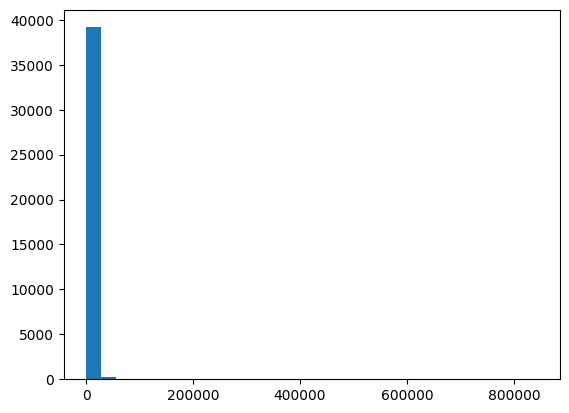

In [9]:
# 1. Plot the target variable. Determine if the target variable seems appropriate or if any transformations are needed.
shares = data.iloc[:, -1]

print(shares.describe())

plt.hist(shares, bins=30)

plt.show()

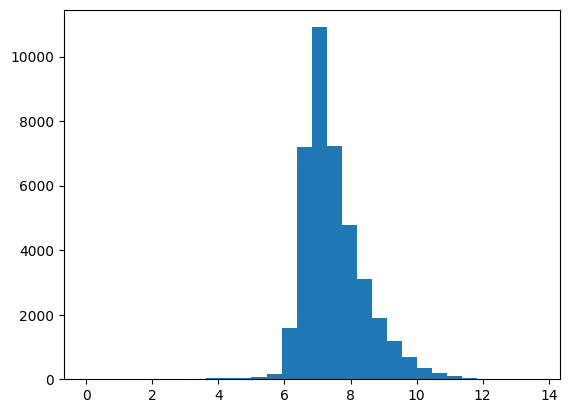

In [12]:
# Apply a log transform because the variables shares are heavily skewed
shares = np.log(shares)

plt.hist(shares, bins=30)

plt.show()

In [ ]:
# 2. Build a linear regression model without higher-order terms and identify the most significant predictors.

In [ ]:
# 3. Build a regression tree to identify important predictors.


In [ ]:
# 4. Select several significant features from steps 2 and 3. Create visualizations or
# tables to explore the relationships between these features and the target variable.

5. Write an EDA section in your technical report. Report the results of the ini-
tial models and include figures or tables that show the target variable and its
relationship with potentially significant predictors.

In [ ]:
# 6. Use appropriate methods to remove insignificant variables from the model.

# Linear Regression Modeling 

In [ ]:
# 1. Split the data into training and testing sets. Use the training set for model fitting
# and the testing set to check for overfitting and predictive performance.

In [ ]:
# 2. Explore transformations of the target and other variables.

In [ ]:
# 3. Explore higher-order terms.

In [ ]:
"""4. Reduce the model using the following methods:
• Stepwise model evaluation methods to remove insignificant variables.
• LASSO regression to fit the full model and remove insignificant variables.
Tune the model to find the best a."""

5. Write a section in your technical report that reports the out-of-sample perfor-
mance of the models. Discuss the most significant predictors and evaluate the
model?s usefulness for predicting future shares.

# Regression Tree Modeling

In [ ]:
# 1. Use the same training and testing sets as above.

In [ ]:
# 2. Use cost-complexity pruning and cross-validation to find a model that fits well
# on out-of-sample data.

In [ ]:
# 3. Fit a random forest regression model, using cost-complexity pruning for the in-
# dividual trees.

In [ ]:
# 4. Write a section in your technical report that reports the out-of-sample perfor-
# mance of the models. Discuss the model's usefulness for predicting future shares.

# Conclusion

Compare each model’s predictive accuracy on the test set. Choose the
best-performing model as the final predictive model. Write a concluding section in
your technical report that addresses Mashable?s business concerns and presents your
final model along with your confidence in its predictions.